# Disaster Tweet Prediction

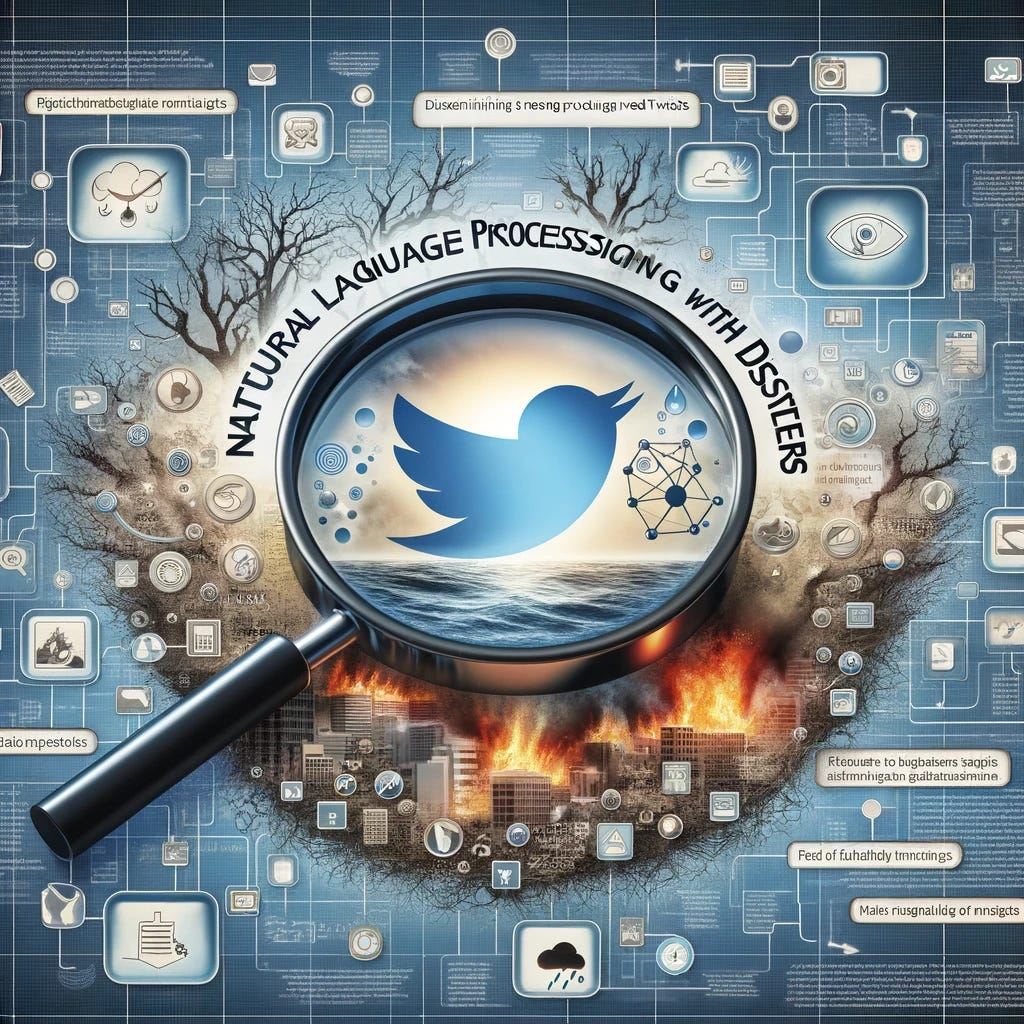
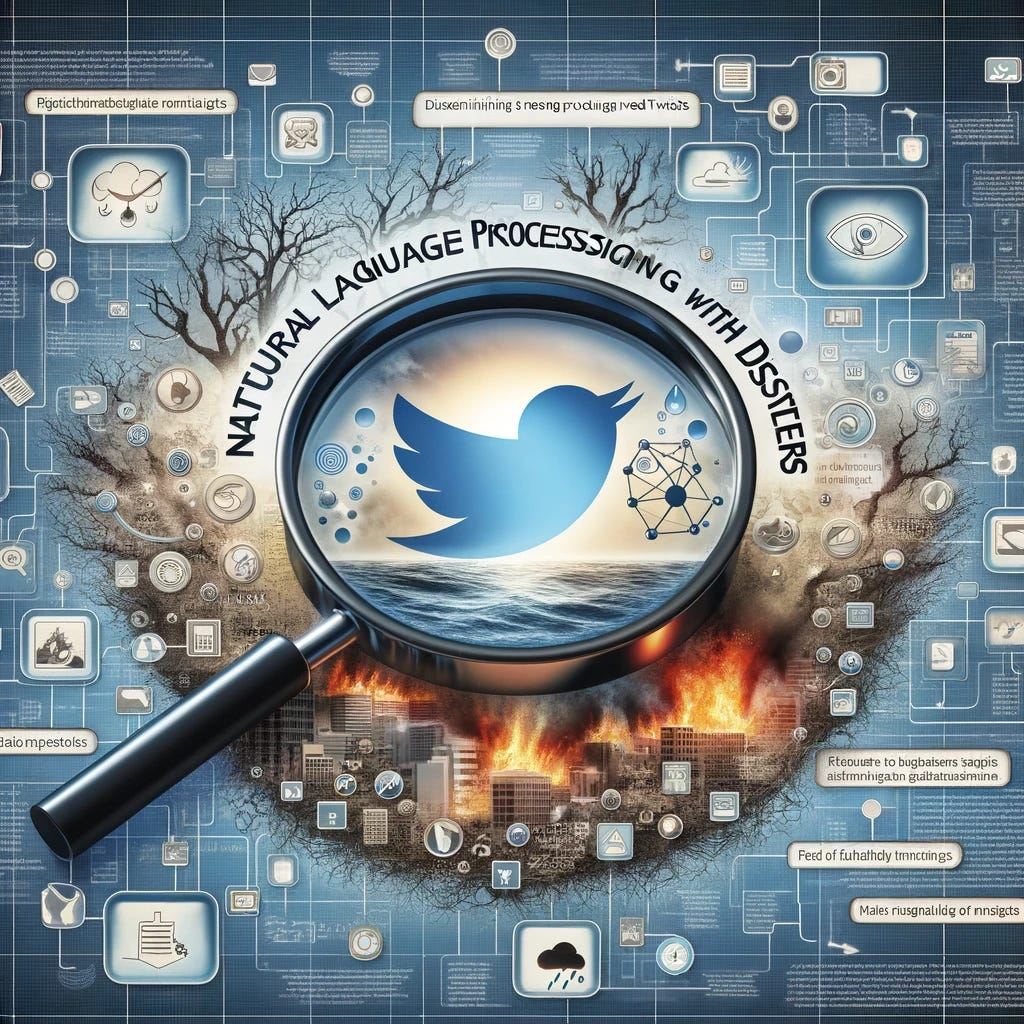

# Disaster Tweet Prediction

## Introduction

The aim of this project is to predict whether a tweet is about a disaster or not. This classification task involves analyzing tweet text data to determine if the tweet refers to a natural disaster, such as an earthquake, fire, or flood. The goal is to create a model that can accurately classify tweets into two categories:

- **Disaster**: The tweet is related to a natural disaster or emergency.
- **Not Disaster**: The tweet is not related to a natural disaster, and could refer to any other topic.

The dataset contains tweets with various types of content, and the goal is to identify patterns in the text data that indicate whether the tweet is about a disaster.

## Dataset Columns

- **id**: Unique identifier for each tweet.
- **keyword**: A keyword from the tweet, which might be related to the disaster. This column could provide additional context but is not always reliable, as some keywords may be missing or generic.
- **location**: The location associated with the tweet. This column may contain geolocation information or could be empty if no location was provided by the user.
- **text**: The text content of the tweet. This is the main feature we will be analyzing to determine if the tweet is about a disaster.
- **target**: The target label indicating if the tweet is about a disaster (1) or not (0). This column will be used as the ground truth in the model's training and evaluation.

## Objective

Our objective is to build a machine learning model that predicts the value of the `target` column based on the `text` data, effectively classifying tweets as related to disasters or not. The model will be trained using features extracted from the tweet text and evaluated for its accuracy in making predictions.

## Requirements

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',None)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import nltk
nltk.download("stopwords")
import re
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import Data

In [18]:
df=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

## EDA (Exploratory Data Analysis)

In [4]:
df.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [5]:
df.shape

(7613, 5)

In [6]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

## Data Visualization

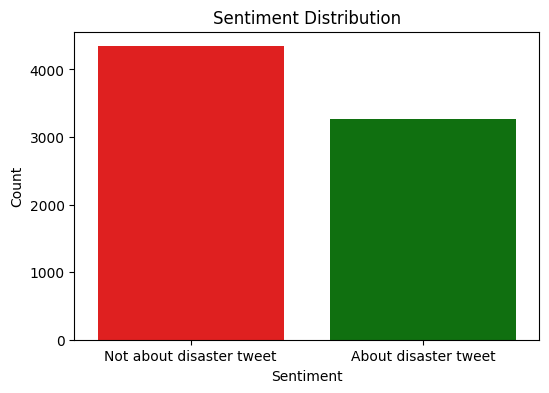

In [9]:
sentiment_counts = df['target'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=["red", "green"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Not about disaster tweet", "About disaster tweet"])
plt.title("Sentiment Distribution")
plt.show()

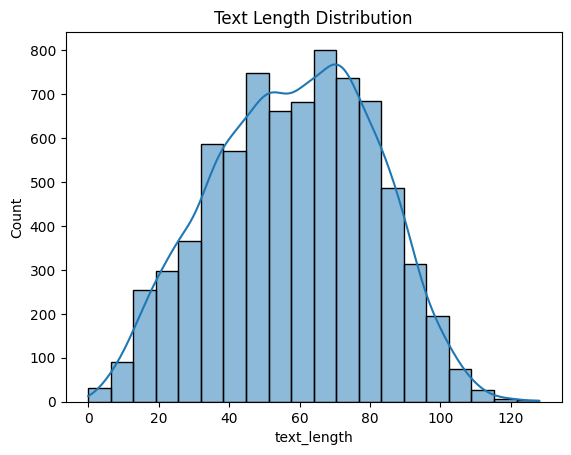

In [48]:
df['text_length'] = df['text'].apply(lambda x: len(str(x)))

# Plot histogram
sns.histplot(df['text_length'], bins=20, kde=True)
plt.title('Text Length Distribution')
plt.show()

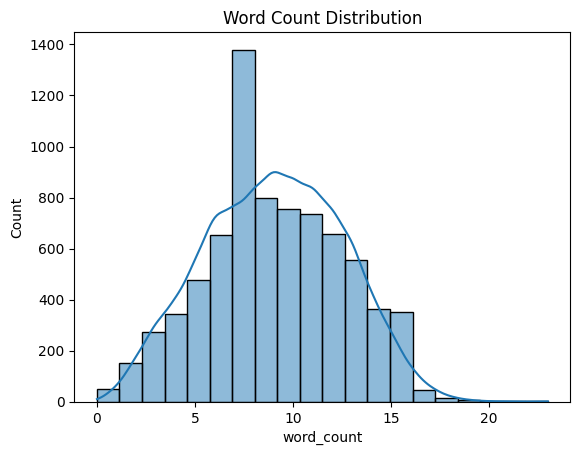

In [49]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Plot histogram
sns.histplot(df['word_count'], bins=20, kde=True)
plt.title('Word Count Distribution')
plt.show()

## Preprocess Text

In [19]:
stemmer=nltk.SnowballStemmer("english")
stopword=set(stopwords.words("english"))
def clean_text(df,text_column):
    # Convert to lowercase
    df[text_column] = df[text_column].str.lower()
    
    # Remove unwanted characters
    df[text_column] = df[text_column].str.replace('[^\w\s]', '', regex=True)
    df[text_column] = df[text_column].str.replace('\w*\d\w*', '', regex=True)
    df[text_column] = df[text_column].str.replace('\n', '', regex=True)
    df[text_column] = df[text_column].str.replace('\r', '', regex=True)
    df[text_column] = df[text_column].str.replace('https?://\S+|www\.\S+', '', regex=True)
    df[text_column] = df[text_column].str.replace('<.*?>+', '', regex=True)
    df[text_column] = df[text_column].str.replace('\[.*?\]', '', regex=True)
    
    # Remove stopwords and apply stemming
    df[text_column] = df[text_column].apply(lambda x: ' '.join(
        stemmer.stem(word) 
        for word in x.split() 
        if word not in stopword
    ))
    return df[text_column]

In [20]:
df.iloc[0]["text"]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [21]:
df["cleaned_text"]=clean_text(df,"text")

In [22]:
df.iloc[0]["cleaned_text"]

'deed reason earthquak may allah forgiv us'

## Word Cloud

In [23]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
def wc(data,color):
    plt.figure(figsize=(10,10))
   # mask=np.array(Image.open('cloud.png'))
    wc=WordCloud(background_color=color,stopwords=STOPWORDS)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

## Word Cloud for non disaster tweets

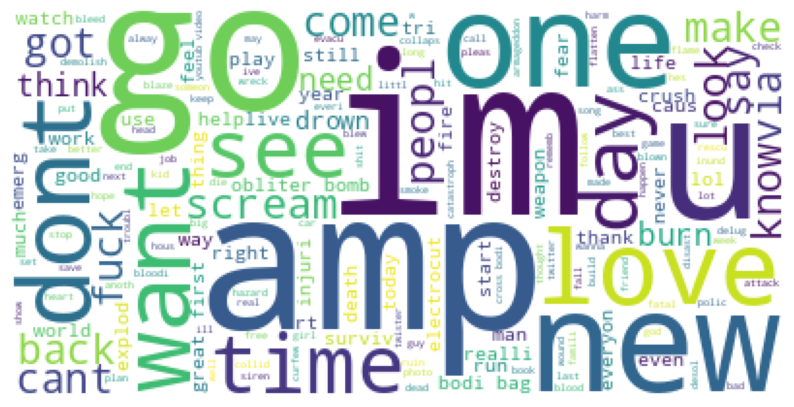

In [24]:
wc(df[df["target"]==0]["text"],"white")

## Word Cloud for disaster tweets

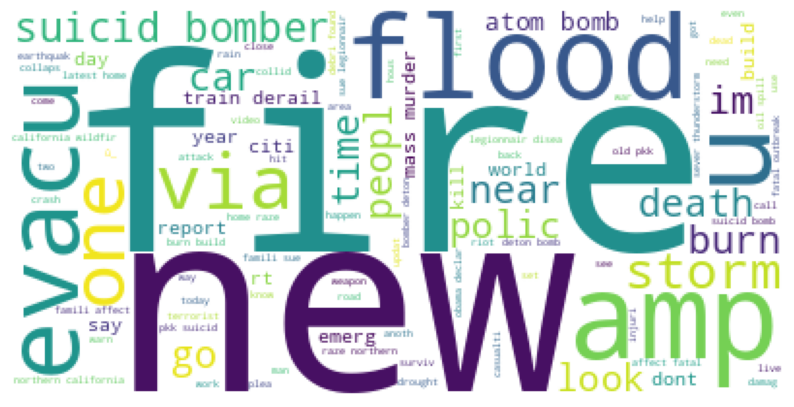

In [25]:
wc(df[df["target"]==1]["text"],"white")

## The Most Used Words for Non Disaster Tweets

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')

portuguese_stopwords = stopwords.words("english") 

def get_top_ngrams(texts, ngram_range=(2, 3), top_n=10):
    vect = CountVectorizer(ngram_range=ngram_range, stop_words=portuguese_stopwords) 
    dtm = vect.fit_transform(texts)
    ngram_counts = dtm.sum(axis=0)
    ngrams_freq = [(word, ngram_counts[0, idx]) for word, idx in vect.vocabulary_.items()]
    return sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:top_n]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
non_disaster_text = df[df['target'] == 0]['text']
non_disaster_text_ngrams = get_top_ngrams(non_disaster_text, ngram_range=(2, 2), top_n=20)
non_disaster_text_ngrams

[('bodi bag', 70),
 ('cross bodi', 38),
 ('look like', 36),
 ('youtub video', 36),
 ('like youtub', 35),
 ('feel like', 27),
 ('full reû_', 25),
 ('full read', 22),
 ('burn build', 22),
 ('reddit quarantin', 21),
 ('content polici', 20),
 ('emerg servic', 18),
 ('via youtub', 18),
 ('quarantin offens', 18),
 ('offens content', 18),
 ('fan armi', 17),
 ('first respond', 17),
 ('prebreak best', 17),
 ('loud bang', 17),
 ('dont know', 16)]

## The Most Used Words for Disaster Tweets

In [33]:
disaster_text = df[df['target'] == 0]['text']
disaster_text_ngrams = get_top_ngrams(disaster_text, ngram_range=(2, 2), top_n=20)
disaster_text_ngrams

[('bodi bag', 70),
 ('cross bodi', 38),
 ('look like', 36),
 ('youtub video', 36),
 ('like youtub', 35),
 ('feel like', 27),
 ('full reû_', 25),
 ('full read', 22),
 ('burn build', 22),
 ('reddit quarantin', 21),
 ('content polici', 20),
 ('emerg servic', 18),
 ('via youtub', 18),
 ('quarantin offens', 18),
 ('offens content', 18),
 ('fan armi', 17),
 ('first respond', 17),
 ('prebreak best', 17),
 ('loud bang', 17),
 ('dont know', 16)]

## Modelling

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.naive_bayes import MultinomialNB    


def classification_test(x,y,vect,confusion_mtr=False):
    b=BernoulliNB()
    l=LogisticRegression()
    d=DecisionTreeClassifier()
    rf=RandomForestClassifier()
    h=GradientBoostingClassifier()
    a=AdaBoostClassifier()
    m=MultinomialNB()
    algos=[b,l,d,rf,h,a,b]

    algo_names=['Bernoulli NB','Logistic Regression','Decision Tree Classifier','Random Forest Classifier','Gradient Boosting Classifier','Ada Boost Classifier','Multinomial NB']

    accuracy=[]
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

    result=pd.DataFrame(columns=['Accuracy Score'],index=algo_names)

    for i, algo in enumerate(algos):
        x_train_dtm = vect.fit_transform(x_train)
        x_test_dtm = vect.transform(x_test)

        if hasattr(algo, 'fit'):
            x_train_dtm = x_train_dtm  
            x_test_dtm = x_test_dtm   

        p = algo.fit(x_train_dtm, y_train).predict(x_test_dtm)
        accuracy.append(accuracy_score(y_test, p))
        if confusion_mtr:
            cm = confusion_matrix(y_test, p)
            plt.figure(figsize=(5, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=algo.classes_, yticklabels=algo.classes_,cbar=None)
            plt.title(f"Confusion Matrix - {algo_names[i]}")
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

    result['Accuracy Score']=accuracy

    r_table=result.sort_values('Accuracy Score',ascending=False)
    
        
        
    return r_table[['Accuracy Score']]

In [35]:
x=df["cleaned_text"]
y=df["target"]

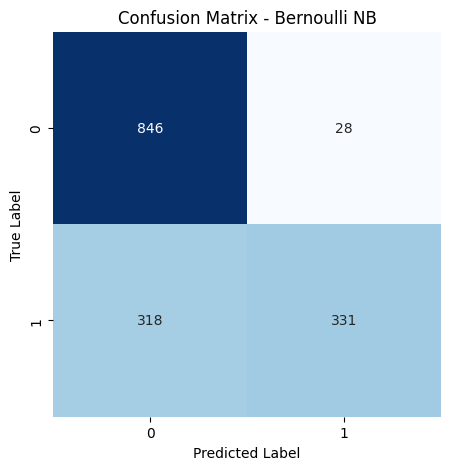

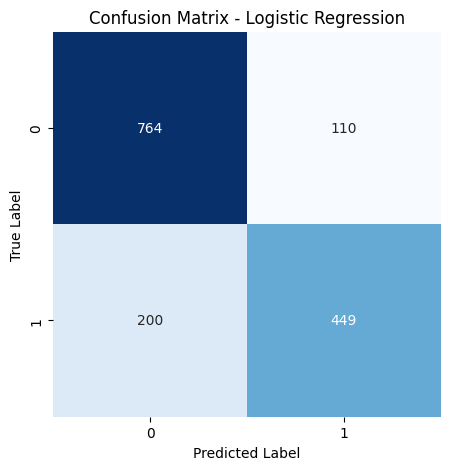

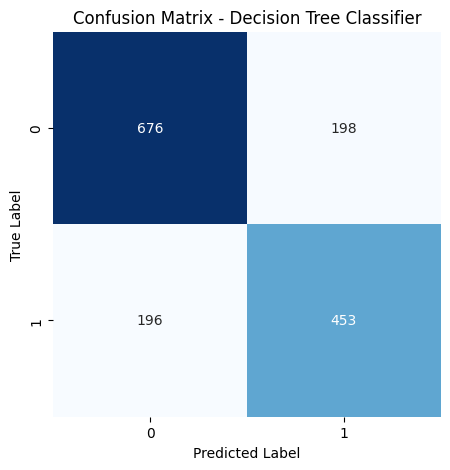

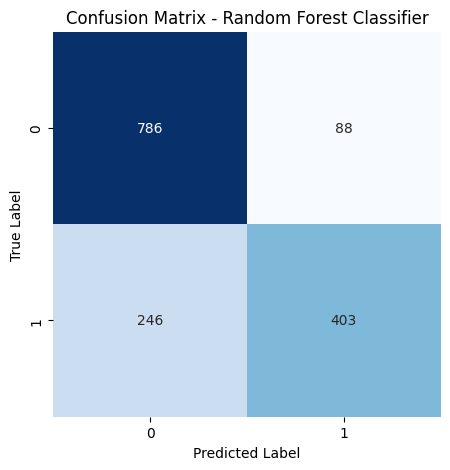

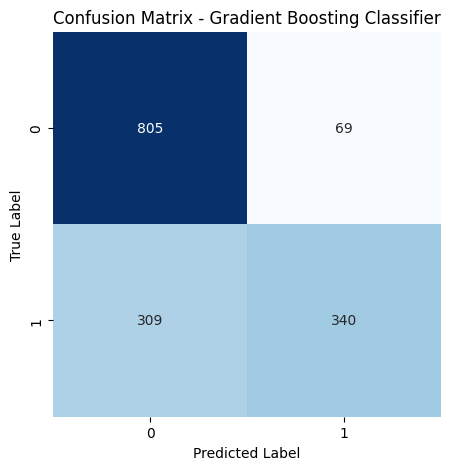

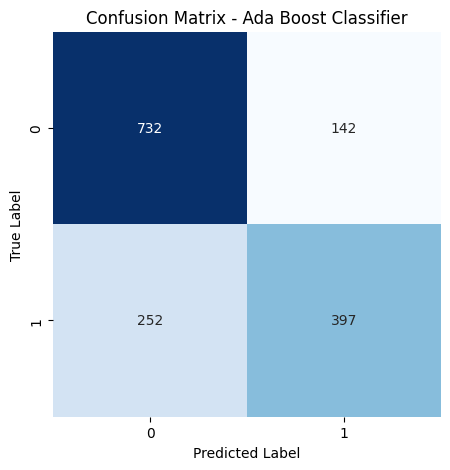

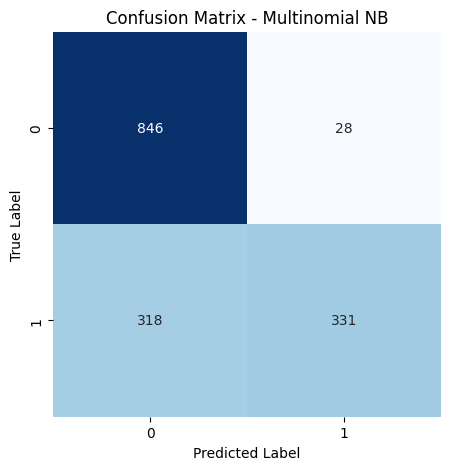

Accuracy Score
Logistic Regression                 0.796454
Random Forest Classifier            0.780696
Bernoulli NB                        0.772817
Multinomial NB                      0.772817
Gradient Boosting Classifier        0.751806
Decision Tree Classifier            0.741300
Ada Boost Classifier                0.741300

In [36]:
vect = CountVectorizer(ngram_range=(1,2))
classification_test(x,y,vect,confusion_mtr=True)

In [37]:
vect = CountVectorizer(ngram_range=(1,2))
l=LogisticRegression()
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)
model=l.fit(x_train_dtm, y_train)

In [38]:
import joblib  

joblib.dump(model, 'logistic_regression_model.pkl')
joblib.dump(vect, 'vectorizer.pkl')

['vectorizer.pkl']

## Testing the Model

In [39]:
df_test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [40]:
df_test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [41]:
df_test["cleaned_text"]=clean_text(df_test,"text")

In [42]:
test_data= vect.transform(df_test["cleaned_text"])
predictions=model.predict(test_data)

In [43]:
df_test["predictions"]=predictions

In [44]:
df_test.head()

id keyword location                                               text  \
0   0     NaN      NaN                           happen terribl car crash   
1   2     NaN      NaN      heard earthquak differ citi stay safe everyon   
2   3     NaN      NaN  forest fire spot pond gees flee across street ...   
3   9     NaN      NaN                     apocalyps light spokan wildfir   
4  11     NaN      NaN                 typhoon soudelor kill china taiwan   

                                        cleaned_text  predictions  
0                           happen terribl car crash            1  
1      heard earthquak differ citi stay safe everyon            1  
2  forest fire spot pond gees flee across street ...            1  
3                     apocalyps light spokan wildfir            1  
4                 typhoon soudelor kill china taiwan            1

In [45]:
submission=pd.DataFrame({
    "id":df_test["id"],
    "target":df_test["predictions"]
})

In [46]:
submission.to_csv("submission.csv",index=False)

## Conclusion

In this project, we aimed to predict whether a tweet is about a disaster or not. Several machine learning models were tested to evaluate their performance in classifying tweets based on their text content.


### Key Insights

- **Logistic Regression** performed the best, with an accuracy score of **0.796454**, making it the most reliable model for this task.
- **Random Forest Classifier** came close to Logistic Regression, with an accuracy of **0.780696**, showing strong performance as well.
- **Bernoulli Naive Bayes** and **Multinomial Naive Bayes** achieved similar accuracy scores of **0.772817**, suggesting they are good at capturing patterns in the data but slightly less effective than Logistic Regression and Random Forest.
- **Gradient Boosting Classifier**, **Decision Tree Classifier**, and **AdaBoost Classifier** performed relatively lower, with accuracy scores ranging between **0.741300** and **0.751806**.

### Conclusion

Overall, Logistic Regression appears to be the most effective model for classifying disaster-related tweets in this dataset. While other models, such as Random Forest and Naive Bayes, also showed promising results, Logistic Regression should be considered the preferred model due to its higher accuracy. 
